# **(d) Análisis de robustez de los grafos.**

d.1 Hacer un análisis de robustez, en el cual se borran los enlaces de un nodo a la vez, hasta borrar todos los enlaces del grafo. 

d.2 Comparar el efecto de borrar seleccionando nodos al azar, con el efecto de ir borrando primero los enlaces de los nodos con mayor centralidad. Usar las medidas de centralidad que se calcularon en el punto anterior.

A medida que se van borrando los enlaces, para grafos no dirigidos cuantificar la robustez de los grafos por dos vías:

1. Calculando el tamaño relativo de la componente gigante resultante ($N_g/N$).
2. Calculando la *eficiencia global* del grafo.

Para grafos dirigidos usar solo $N_g/N$ (ya que la eficiencia global no está implementada para grafos dirigidos).

In [11]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms.approximation import average_clustering
import community.community_louvain as cl
import pickle
import random

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
import seaborn as sns

from sklearn.metrics import adjusted_rand_score

# Funciones de utiles.py
from utiles import read_graph , read_graph_weighted,get_graph_pos , drop_weights

## 0. Carga de datos
Primero, leemos los dos datasets y las etiquetas del dataset de email.

Las etiquetas para email indican a que departamento pertenece cada nodo (por ej. el nodo 3 pertenece al departamento 21

In [12]:
EMAIL_PATH = 'datasets/email.txt'
TERRORIST_PATH = 'datasets/terrorist.txt'
EMAIL_LABELS_PATH = 'datasets/email_labels.txt'

# Leemos los grafos
email = read_graph(EMAIL_PATH)
terr= read_graph_weighted(TERRORIST_PATH)

# Leemos las etiquetas del dataset de email
array = np.loadtxt(EMAIL_LABELS_PATH, dtype=int)
email_labels=list(array[:,1]) 

Posteriormente, cargamos los datasets con la centralidad por grado e intermediación para ambos sets de datos (los utilizaremos para eliminar según la centralidad)

In [13]:
# Cargar centralidades desde CSVs

# Terrorist Unweighted
terrorist_intermediacion = pd.read_csv('datasets/centralidad/terrorist_unweighted_intermediacion.csv')
terrorist_grado = pd.read_csv('datasets/centralidad/terrorist_unweighted_grado.csv')

# Email Giant
email_intermediacion = pd.read_csv('datasets/centralidad/email_giant_intermediacion.csv')
email_grado = pd.read_csv('datasets/centralidad/email_giant_grado.csv')

Después, quitamos los pesos al grafo de terroristas para poderlo estudiar.

In [14]:
terrorist_unweighted = terr.copy()
drop_weights(terrorist_unweighted)
terrorist_unweighted.remove_edges_from(nx.selfloop_edges(terrorist_unweighted)) #remuevo autoenlaces NO HAY
print(terrorist_unweighted)

Graph with 64 nodes and 243 edges


Nos quedamos solo con el componente gigante de email, ya que no está completamente conectado.

In [15]:
email.remove_edges_from(nx.selfloop_edges(email))  # Borrar autoenlaces
emailcc = sorted(nx.connected_components(email), key=len, reverse=True)
email_giant = email.subgraph(emailcc[0])

## 1. Análisis de robustez
### 1.0. Definición funciones de eliminación de nodos

In [24]:
def random_node_removal_full(G, plot=True):
    """
    Elimina nodos uno a uno aleatoriamente hasta destruir completamente el grafo.
    Calcula eficiencia global con menor frecuencia si el grafo es grande.
    """

    G_temp = G.copy()
    nodos = list(G_temp.nodes())
    random.shuffle(nodos)

    N_total = G_temp.number_of_nodes()
    ng_list = []
    eff_list = []

    # Frecuencia adaptativa del cálculo de eficiencia
    is_large = N_total > 100

    #Nota: Colocar frecuencia 5 demora 2 min, con frecuencia 20 demora 20 segundos
    freq_eff = 1 if is_large else 1  # cada cuántos pasos se calcula eficiencia

    i = 0
    while nodos and G_temp.number_of_edges() > 0:
        node = nodos.pop()
        G_temp.remove_node(node)
        i += 1

        if G_temp.number_of_nodes() > 1:
            giant_cc = max(nx.connected_components(G_temp), key=len)
            Ng = len(giant_cc) / N_total
            # Solo calculo eficiencia cada freq_eff pasos
            if i % freq_eff == 0 or not eff_list:
                eff = nx.global_efficiency(G_temp)
            else:
                eff = eff_list[-1]  # repetir último valor
        else:
            Ng = 0
            eff = 0

        ng_list.append(Ng)
        eff_list.append(eff)

    if plot:
        fig, ax1 = plt.subplots(figsize=(6, 3.5))
        x_vals = range(1, len(ng_list) + 1)

        ax1.plot(x_vals, ng_list, color='royalblue', linewidth=2, label='$N_g/N$')
        ax1.set_ylabel('$N_g/N$', color='royalblue', fontsize=10)
        ax1.set_xlabel('Nodos eliminados', fontsize=10)
        ax1.tick_params(axis='y', labelcolor='royalblue', labelsize=9)
        ax1.tick_params(axis='x', labelsize=9)

        ax2 = ax1.twinx()
        ax2.plot(x_vals, eff_list, color='firebrick', linewidth=2, label='Eficiencia global')
        ax2.set_ylabel('Eficiencia global', color='firebrick', fontsize=10)
        ax2.tick_params(axis='y', labelcolor='firebrick', labelsize=9)

        plt.title('Robustez: eliminación aleatoria de nodos', fontsize=11)
        fig.tight_layout()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.show()

    return ng_list, eff_list



In [17]:
def targeted_node_removal_stepwise(G, ordered_nodes, title="Robustez: eliminación dirigida de nodos", plot=True):
    """
    Elimina nodos de un grafo según un orden dado, midiendo robustez en cada paso.

    Parámetros:
    - G: grafo original (se trabaja sobre una copia).
    - ordered_nodes: lista de nodos ordenados (mayor a menor centralidad).
    - plot: si True, grafica evolución de Ng/N y eficiencia global.
    - title: título personalizado para el gráfico.

    Devuelve:
    - ng_list: evolución del tamaño relativo de la componente gigante.
    - eff_list: evolución de la eficiencia global.
    """

    G_temp = G.copy()
    N_total = G_temp.number_of_nodes()
    ng_list = []
    eff_list = []

    for node in ordered_nodes:
        if node in G_temp:
            G_temp.remove_node(node)

            if G_temp.number_of_nodes() > 0 and G_temp.number_of_edges() > 0:
                giant_cc = max(nx.connected_components(G_temp), key=len)
                Ng = len(giant_cc) / N_total
                eff = nx.global_efficiency(G_temp)
            else:
                Ng = 0
                eff = 0

            ng_list.append(Ng)
            eff_list.append(eff)

            if Ng == 0:
                break

    if plot:
        fig, ax1 = plt.subplots(figsize=(6, 3.5))

        x_vals = range(1, len(ng_list) + 1)

        ax1.plot(x_vals, ng_list, color='royalblue', linewidth=2, label='$N_g/N$')
        ax1.set_ylabel('$N_g/N$', color='royalblue', fontsize=10)
        ax1.set_xlabel('Nodos eliminados', fontsize=10)
        ax1.tick_params(axis='y', labelcolor='royalblue', labelsize=9)
        ax1.tick_params(axis='x', labelsize=9)

        ax2 = ax1.twinx()
        ax2.plot(x_vals, eff_list, color='firebrick', linewidth=2, label='Eficiencia global')
        ax2.set_ylabel('Eficiencia global', color='firebrick', fontsize=10)
        ax2.tick_params(axis='y', labelcolor='firebrick', labelsize=9)

        plt.title(title, fontsize=11)
        fig.tight_layout()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.show()

    return ng_list, eff_list





### 1.1. Terroristas
#### 1.1.1. Eliminación aleatoria

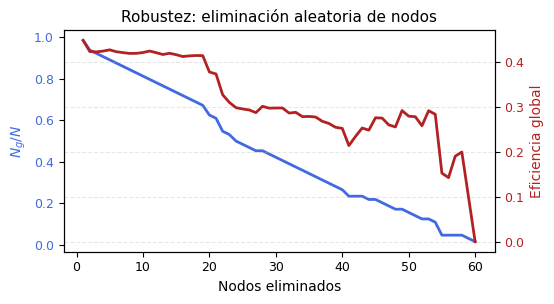

In [18]:
terrorist_unweighted_copy = terrorist_unweighted.copy()
terr_ng_list, terr_eff_list = random_node_removal_full(terrorist_unweighted_copy)

#### 1.1.2. Eliminación según centralidad de grado

Nodos ordenados de mayor a menor centralidad de grado: 
[0, 2, 6, 9, 24, 15, 17, 16, 21, 29, 20, 22, 19, 13, 14, 23, 48, 3, 25, 28, 4, 12, 11, 10, 27, 18, 45, 5, 49, 35, 7, 30, 50, 51, 52, 40, 46, 58, 43, 39, 55, 54, 8, 26, 56, 44, 57, 1, 31, 33, 62, 63, 60, 36, 38, 32, 53, 42, 41, 37, 34, 59, 47, 61]


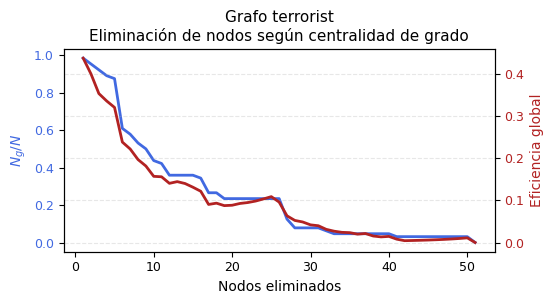

In [19]:
terrorist_grado_nodos = list(terrorist_grado["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de grado: \n{terrorist_grado_nodos}")

# Luego sí usar en la función:
terrorist_unweighted_copy = terrorist_unweighted.copy()
terrorist_ng_list_grado, terrorist_eff_list_grado = targeted_node_removal_stepwise(
    terrorist_unweighted_copy, terrorist_grado_nodos, "Grafo terrorist\nEliminación de nodos según centralidad de grado"
)


#### 1.1.3. Eliminación según centralidad de intermediación

Nodos ordenados de mayor a menor centralidad de intermediación: 
[48, 0, 2, 23, 6, 21, 17, 16, 29, 18, 9, 45, 24, 5, 15, 22, 14, 35, 44, 43, 20, 58, 30, 19, 13, 7, 51, 50, 49, 52, 25, 40, 39, 38, 31, 32, 28, 27, 8, 12, 1, 4, 26, 3, 11, 10, 36, 34, 55, 54, 53, 42, 41, 33, 37, 56, 63, 62, 59, 57, 46, 47, 60, 61]


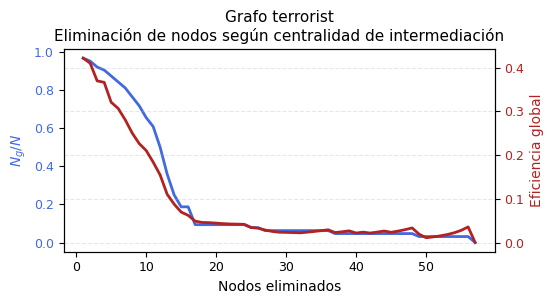

In [21]:
terrorist_intermediacion_nodos = list(terrorist_intermediacion["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de intermediación: \n{terrorist_intermediacion_nodos}")

# Luego sí usar en la función:
terrorist_unweighted_copy = terrorist_unweighted.copy()
terrorist_ng_list_int, terrorist_eff_list_int = targeted_node_removal_stepwise(
    terrorist_unweighted_copy, terrorist_intermediacion_nodos, "Grafo terrorist\nEliminación de nodos según centralidad de intermediación"
)


### 1.2. Email
#### 1.2.1. Eliminación aleatoria

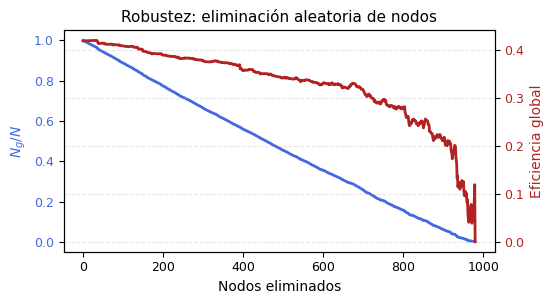

In [25]:
email_giant_copy = email_giant.copy()
email_ng_list, email_eff_list = random_node_removal_full(email_giant_copy)


#### 1.2.2. Eliminación según centralidad de grado

Nodos ordenados de mayor a menor centralidad de grado en email:
[160, 121, 82, 107, 86, 62, 434, 13, 166, 183, 5, 64, 249, 129, 533, 211, 128, 105, 114, 283, 106, 142, 83, 420, 87, 377, 282, 21, 333, 424, 84, 115, 301, 820, 256, 58, 63, 405, 280, 252, 212, 96, 169, 165, 494, 6, 81, 17, 473, 133, 340, 44, 411, 366, 28, 303, 419, 546, 932, 170, 329, 971, 4, 2, 74, 365, 215, 172, 232, 41, 65, 285, 498, 493, 371, 113, 93, 210, 409, 295, 209, 137, 438, 269, 404, 367, 254, 393, 116, 141, 290, 180, 173, 474, 549, 23, 14, 184, 495, 155, 157, 168, 300, 11, 189, 16, 42, 459, 450, 859, 20, 486, 342, 296, 174, 46, 518, 222, 7, 80, 19, 89, 440, 152, 61, 3, 145, 362, 412, 167, 271, 51, 218, 856, 30, 375, 57, 233, 162, 417, 226, 255, 455, 231, 263, 69, 506, 27, 221, 338, 132, 526, 351, 615, 812, 305, 191, 181, 281, 206, 318, 339, 131, 426, 40, 48, 35, 363, 258, 29, 12, 223, 321, 201, 441, 427, 560, 18, 612, 278, 187, 513, 408, 509, 520, 443, 60, 179, 358, 177, 379, 460, 430, 153, 154, 355, 163, 531, 

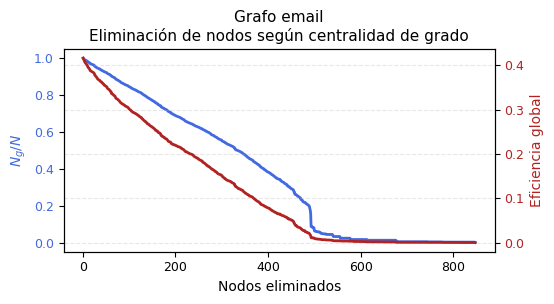

In [22]:
email_grado_nodos = list(email_grado["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de grado en email:\n{email_grado_nodos}")

email_giant_copy = email_giant.copy()
email_ng_list_grado, email_eff_list_grado = targeted_node_removal_stepwise(
    email_giant_copy, email_grado_nodos, "Grafo email\nEliminación de nodos según centralidad de grado"
)


#### 1.2.3. Eliminación según centralidad de intermediación

Nodos ordenados de mayor a menor centralidad de intermediación en email:
[160, 86, 5, 82, 121, 107, 13, 377, 62, 64, 211, 533, 84, 166, 971, 434, 411, 129, 65, 6, 183, 333, 301, 96, 21, 820, 44, 249, 106, 128, 420, 114, 405, 546, 191, 340, 87, 115, 283, 295, 498, 63, 232, 282, 83, 58, 269, 290, 209, 280, 2, 414, 424, 494, 285, 142, 105, 231, 215, 462, 560, 137, 495, 393, 81, 170, 258, 412, 133, 252, 141, 4, 165, 366, 506, 493, 256, 17, 157, 401, 303, 180, 28, 473, 189, 409, 184, 443, 12, 306, 329, 419, 440, 74, 404, 321, 353, 549, 365, 509, 173, 376, 169, 11, 20, 543, 14, 375, 113, 19, 155, 93, 61, 41, 342, 417, 271, 238, 177, 263, 23, 327, 168, 300, 69, 212, 89, 466, 27, 145, 57, 18, 172, 242, 748, 408, 52, 38, 459, 7, 206, 438, 255, 381, 367, 856, 544, 380, 936, 474, 163, 325, 452, 230, 92, 932, 851, 516, 537, 526, 210, 222, 88, 350, 179, 55, 421, 564, 371, 521, 777, 326, 577, 450, 812, 859, 15, 51, 379, 430, 218, 116, 611, 425, 316, 641, 162, 605, 486, 370, 234, 80, 717, 72, 712, 63

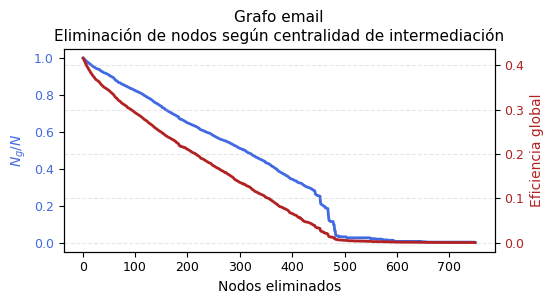

In [23]:
email_intermediacion_nodos = list(email_intermediacion["nodo"])
print(f"Nodos ordenados de mayor a menor centralidad de intermediación en email:\n{email_intermediacion_nodos}")

email_giant_copy = email_giant.copy()
email_ng_list_int, email_eff_list_int = targeted_node_removal_stepwise(
    email_giant_copy, email_intermediacion_nodos, "Grafo email\nEliminación de nodos según centralidad de intermediación"
)